<a href="https://colab.research.google.com/github/melodiw82/FoodClassification_DL/blob/main/FoodClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras
import keras_tuner as kt
import seaborn as sns

#models 
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB3, EfficientNetB5, EfficientNetB7, MobileNetV3Large, ConvNeXtBase 

#preproces
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

from collections import Counter


2024-12-08 09:16:25.546260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 09:16:25.546416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 09:16:25.671541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SIZE = 224
BS = 16

## Data Load

In [3]:
imgs = glob(r'/kaggle/input/food41/images/*/*')
labels = [el.split('/')[5] for el in imgs ]

## Visualisation

In [5]:
def visualisation(imgs, choise):
    
    fig, ax = plt.subplots(5, 3, figsize=(20, 20))
    fig.subplots_adjust()
    im_list = np.random.choice(imgs, choise)
    for axi, im in zip( ax.flat, im_list):
        axi.set_title(im.split('/')[5],)
        axi.imshow(plt.imread(im), )

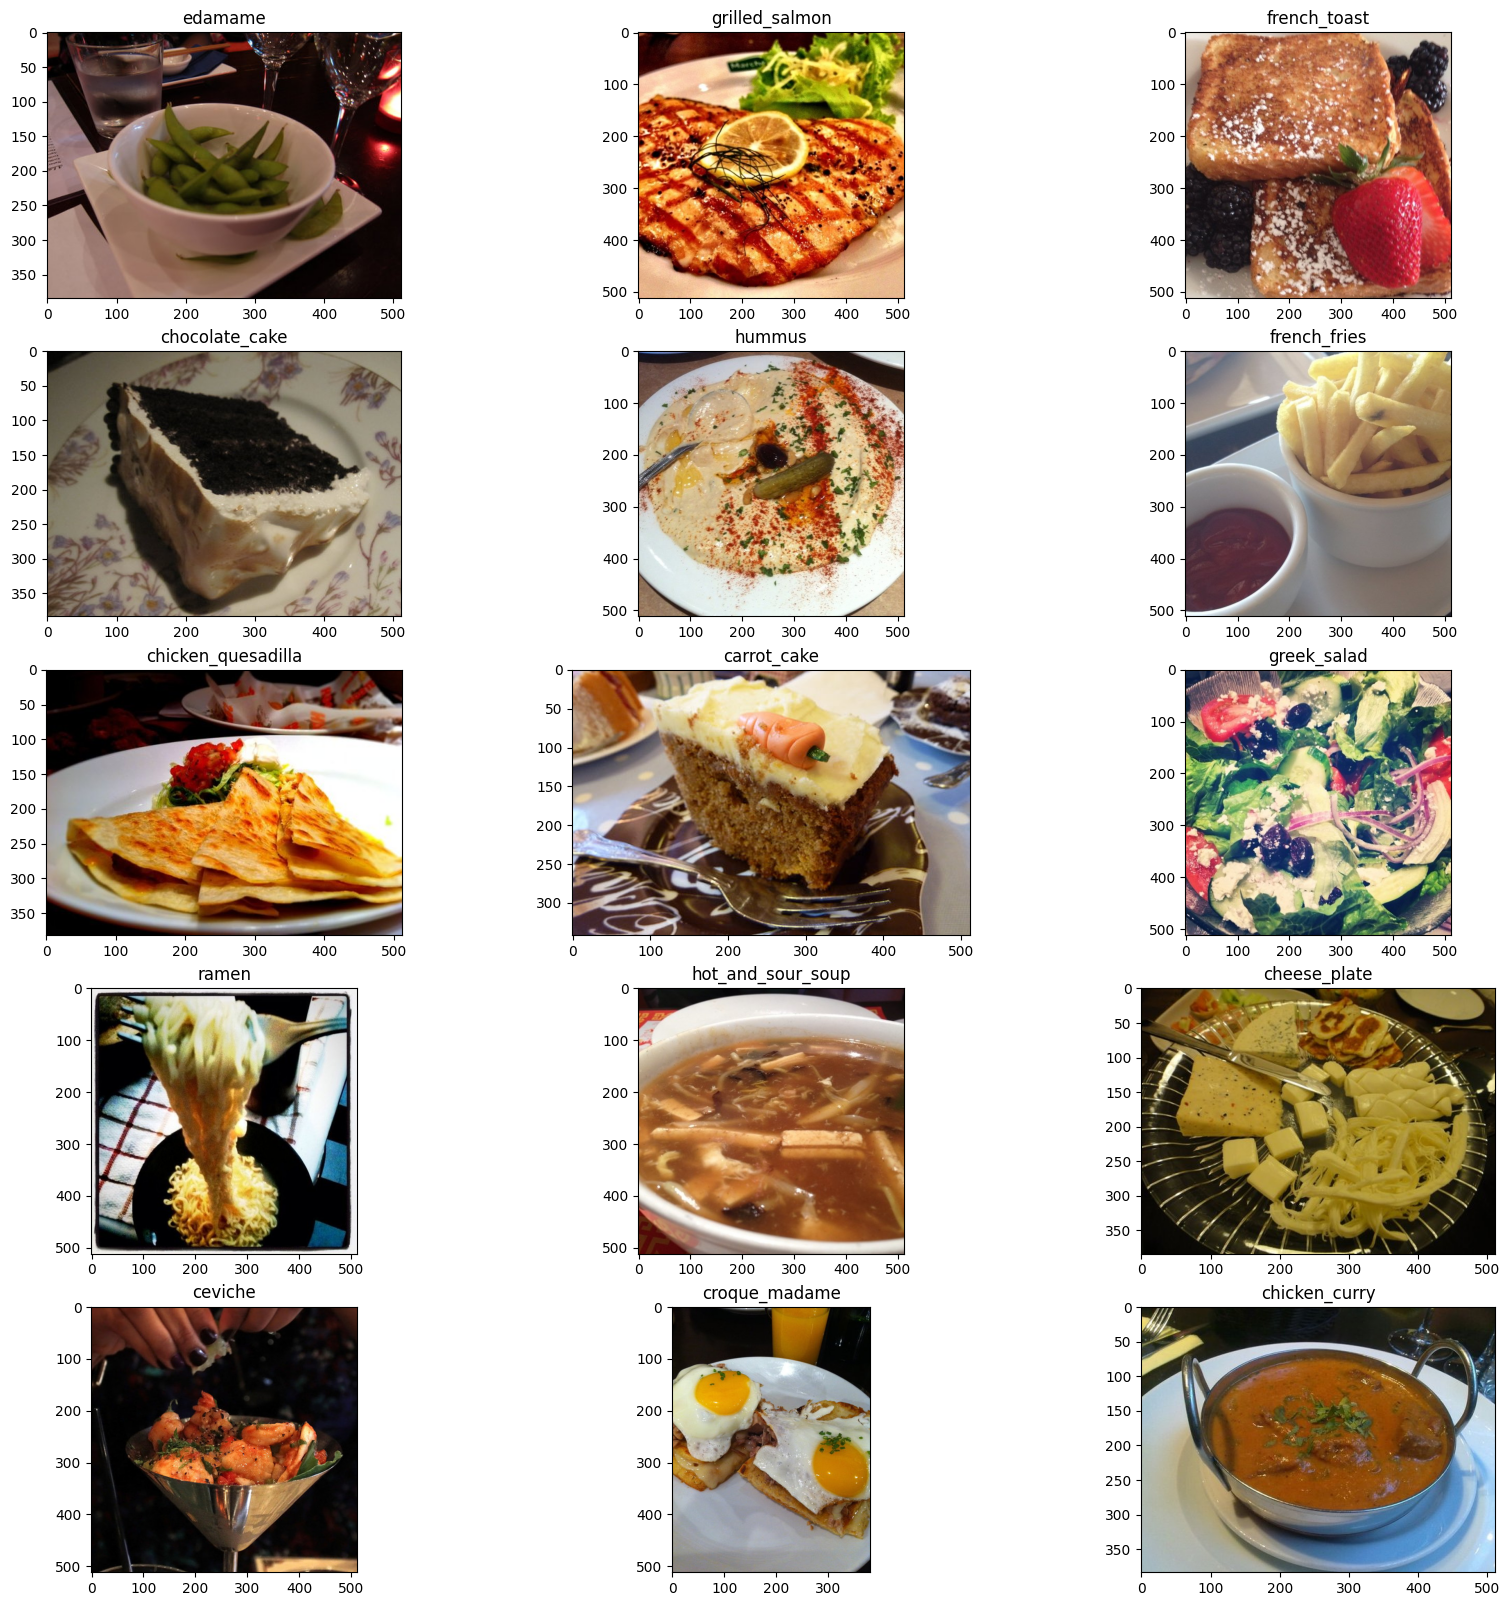

In [6]:

visualisation(imgs, 15)

## Class distribution

In [24]:
distribution_dict = {k:np.round(v*100/len(labels), 1) for k,v in Counter(labels).items()} 
set(distribution_dict.values())

{1.0}

In [25]:
counter_dict = {k:v for k,v in Counter(labels).items()} 


df = pd.DataFrame(counter_dict.items(),columns =['name', 'count'] )
df.describe()



,count
count,101.0
mean,1000.0
std,0.0
min,1000.0
25%,1000.0
50%,1000.0
75%,1000.0
max,1000.0


In [27]:
len(imgs), len(labels)

(101000, 101000)

## Make DF

In [4]:

df = pd.DataFrame(list(zip(imgs, labels)), columns =['X','y'])


In [29]:

df['y'].value_counts()

y
macarons            1000
steak               1000
gyoza               1000
chocolate_cake      1000
tuna_tartare        1000
                    ... 
fried_calamari      1000
omelette            1000
clam_chowder        1000
shrimp_and_grits    1000
french_fries        1000
Name: count, Length: 101, dtype: int64

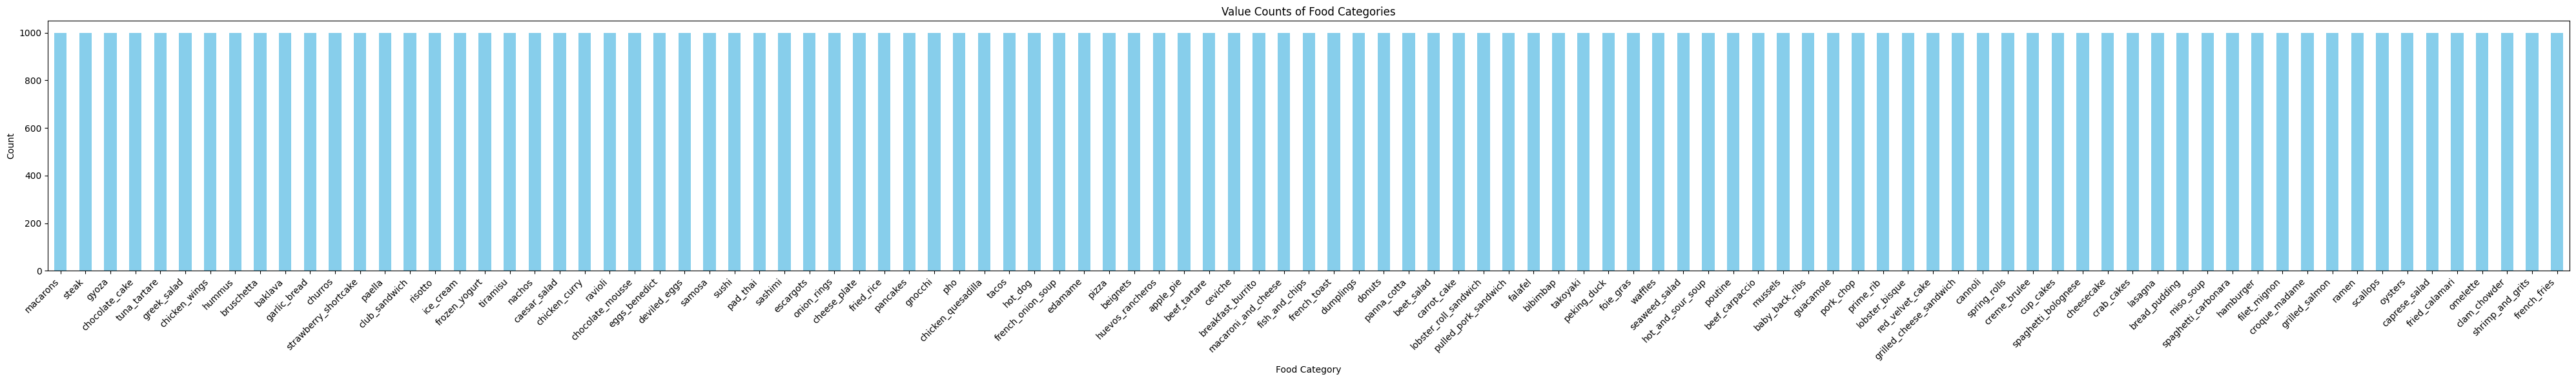

In [31]:


plt.figure(figsize=(40, 6))

df['y'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Food Category')
plt.ylabel('Count')
plt.title('Value Counts of Food Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Take 10 % of dataset for tuning

In [6]:
df = df.iloc[:10100]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X       10100 non-null  object
 1   y       10100 non-null  object
dtypes: object(2)
memory usage: 157.9+ KB


In [7]:
df['y'].unique()

array(['macarons', 'french_toast', 'lobster_bisque', 'prime_rib',
       'pork_chop', 'guacamole', 'baby_back_ribs', 'mussels',
       'beef_carpaccio', 'poutine', 'hot_and_sour_soup'], dtype=object)

In [8]:

#train, test = train_test_split(df, test_size=0.9, random_state=42)
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, 
        brightness_range=(1.0, 0.8),)
valid_gen = ImageDataGenerator(rescale=1./255)

In [10]:


train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE))



Found 8080 validated image filenames belonging to 11 classes.
Found 2020 validated image filenames belonging to 11 classes.


## Search a basic model

In [11]:
def build_model(hp, num_classes=11, shape=(SIZE,SIZE,3)):
    
    inputs = tf.keras.layers.Input(shape=shape)
    

    efb3 = EfficientNetB3(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None)
    
    
    efb1 = EfficientNetB1(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)
    
    mnv3 = MobileNetV3Large(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)

    
    
    hp_model = hp.Choice('model', values=['efb3', 'efb1','mnv3'])
    
    if hp_model == 'efb3':
        model = efb3  
    elif hp_model == 'mnv3':
        model = mnv3
    elif hp_model == 'efb1':
        model = efb1  
    else:
        raise
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    
    dropout_rate = 0.6
    x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs)
    
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=0.5,
        gamma=2,
        from_logits=False)
    
    learning_rate = 1e-3 #2
    
 
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [12]:

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5, seed=123, overwrite = True)



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:

tuner.search(train_gen, epochs=7, validation_data=test_gen)

Trial 3 Complete [00h 16m 52s]
val_loss: 0.24462668597698212

Best val_loss So Far: 0.24462668597698212
Total elapsed time: 00h 49m 58s


In [14]:

tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
model: efb1
Score: 0.24462668597698212

Trial 0 summary
Hyperparameters:
model: efb3
Score: 0.3032725155353546

Trial 1 summary
Hyperparameters:
model: mnv3
Score: 1.1752748489379883


In [15]:

best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'model': 'efb1'}

## Hyperparameters search

In [17]:
def build_model(hp, num_classes=11, shape=(SIZE,SIZE,3)):
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB1(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        #classes=num_classes,
        classifier_activation='softmax')
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    
    hp_top_dropout_rate = hp.Choice('top_dropout_rate', values=[0.3, 0.5, 0.7])
    x = tf.keras.layers.Dropout( hp_top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    hp_gamma = hp.Choice('gamma', values=[2, 4, 6])
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=0.5,
        gamma=hp_gamma,
        from_logits=False)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'rmsprop','nadam'])
    if hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=hp_learning_rate)
    else:
        raise
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [20]:

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5, seed=123,overwrite = True)

In [21]:
tuner.search(train_gen, epochs=7, validation_data=test_gen)

Trial 5 Complete [00h 14m 42s]
val_loss: 0.8682048916816711

Best val_loss So Far: 0.05390848591923714
Total elapsed time: 01h 18m 03s


In [22]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
top_dropout_rate: 0.3
gamma: 6
learning_rate: 0.0001
optimizer: rmsprop
Score: 0.05390848591923714

Trial 3 summary
Hyperparameters:
top_dropout_rate: 0.7
gamma: 4
learning_rate: 0.01
optimizer: sgd
Score: 0.0750807374715805

Trial 1 summary
Hyperparameters:
top_dropout_rate: 0.3
gamma: 6
learning_rate: 0.001
optimizer: rmsprop
Score: 0.11185209453105927

Trial 2 summary
Hyperparameters:
top_dropout_rate: 0.3
gamma: 4
learning_rate: 0.001
optimizer: rmsprop
Score: 0.25643354654312134

Trial 4 summary
Hyperparameters:
top_dropout_rate: 0.7
gamma: 4
learning_rate: 0.0001
optimizer: sgd
Score: 0.8682048916816711


In [23]:

best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'top_dropout_rate': 0.3,
 'gamma': 6,
 'learning_rate': 0.0001,
 'optimizer': 'rmsprop'}

## Conclusioon
The best model is EfficientNetB1

### Hyperparameters
* top_dropout_rate: 0.3,
* gamma: 6,
* learning_rate: 0.0001,
* optimizer: 'rmsprop'